In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

plt.rcParams["font.family"] = "Malgun Gothic"   # Windows면 보통 이걸로
plt.rcParams["axes.unicode_minus"] = False      # 마이너스 기호 깨짐 방지

In [2]:
GEN_PATH = "한국전력거래소_지역별 시간별 태양광 및 풍력 발전량_2024.csv"
WX_PATH  = "OBS_ASOS_TIM_20251215090557.csv"

In [3]:
def read_csv_kor(path):
    for enc in ["cp949", "euc-kr", "utf-8-sig", "utf-8"]:
        try:
            return pd.read_csv(path, encoding=enc, low_memory=False)
        except Exception:
            pass
    return pd.read_csv(path, low_memory=False)

def show_df(title, df, n=50):
    """이 환경이면 표를 UI로, 아니면 콘솔 출력"""
    try:
        from caas_jupyter_tools import display_dataframe_to_user
        display_dataframe_to_user(title, df)
    except Exception:
        print(f"\n[{title}]")
        print(df.head(n).to_string(index=False))

def safe_corr(df):
    return df.corr(numeric_only=True)

def corr_heatmap(corr, title):
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(corr.values)
    ax.set_title(title)
    ax.set_xticks(range(len(corr.columns)))
    ax.set_yticks(range(len(corr.index)))
    ax.set_xticklabels(corr.columns, rotation=45, ha="right")
    ax.set_yticklabels(corr.index)
    plt.tight_layout()
    plt.show()

In [4]:
gen = read_csv_kor(GEN_PATH)
wx  = read_csv_kor(WX_PATH)

In [5]:
gen_wind = gen.loc[gen["연료원"] == "풍력", ["거래일자", "거래시간", "지역", "전력거래량(MWh)"]].copy()
gen_wind["거래일자"] = pd.to_datetime(gen_wind["거래일자"], errors="coerce")
gen_wind["거래시간"] = pd.to_numeric(gen_wind["거래시간"], errors="coerce")
gen_wind["dt"] = gen_wind["거래일자"] + pd.to_timedelta(gen_wind["거래시간"] - 1, unit="h")
gen_wind["region"] = gen_wind["지역"].map({"육지": "Mainland", "제주": "Jeju"})
gen_wind = (gen_wind.rename(columns={"전력거래량(MWh)": "wind_mwh"})
                    .loc[:, ["dt", "region", "wind_mwh"]]
                    .dropna())

In [6]:
keep = ["지점", "지점명", "일시", "풍속(m/s)", "풍향(16방위)", "기온(°C)", "현지기압(hPa)", "습도(%)", "강수량(mm)"]
wx = wx[keep].copy()

wx["dt"] = pd.to_datetime(wx["일시"], errors="coerce")
wx = wx.drop(columns=["일시"]).dropna(subset=["dt"])

num_cols = ["풍속(m/s)", "풍향(16방위)", "기온(°C)", "현지기압(hPa)", "습도(%)", "강수량(mm)"]
for c in num_cols:
    wx[c] = pd.to_numeric(wx[c], errors="coerce")

jeju_names = {"제주", "서귀포", "고산", "성산"}  # 필요 시 조정
wx["region"] = np.where(wx["지점명"].isin(jeju_names), "Jeju", "Mainland")

# 시간×지역 평균(지점 다수 -> 대표 기상)
wx_agg = wx.groupby(["region", "dt"], as_index=False)[num_cols].mean()

In [7]:
df = (gen_wind.merge(wx_agg, on=["region", "dt"], how="inner")
              .sort_values(["region", "dt"])
              .reset_index(drop=True))

In [8]:
# A) 데이터 크기/기간
summary = pd.DataFrame({
    "dataset": ["gen_wind", "wx_agg", "merged"],
    "rows": [len(gen_wind), len(wx_agg), len(df)],
    "cols": [gen_wind.shape[1], wx_agg.shape[1], df.shape[1]],
})
ranges = pd.DataFrame({
    "dataset": ["gen_wind", "wx_agg", "merged"],
    "start": [gen_wind["dt"].min(), wx_agg["dt"].min(), df["dt"].min()],
    "end":   [gen_wind["dt"].max(), wx_agg["dt"].max(), df["dt"].max()],
})
show_df("EDA-1) dataset sizes", summary)
show_df("EDA-2) date ranges", ranges)


[EDA-1) dataset sizes]
 dataset  rows  cols
gen_wind 17568     3
  wx_agg 17568     8
  merged 17568     9

[EDA-2) date ranges]
 dataset      start                 end
gen_wind 2024-01-01 2024-12-31 23:00:00
  wx_agg 2024-01-01 2024-12-31 23:00:00
  merged 2024-01-01 2024-12-31 23:00:00


In [9]:
# B) 커버리지(지역별 시간 개수)
coverage = (df.groupby("region", as_index=False)
              .agg(hours=("dt", "nunique"),
                   start=("dt", "min"),
                   end=("dt", "max")))
show_df("EDA-3) coverage by region", coverage)


[EDA-3) coverage by region]
  region  hours      start                 end
    Jeju   8784 2024-01-01 2024-12-31 23:00:00
Mainland   8784 2024-01-01 2024-12-31 23:00:00


In [10]:
# C) 결측률(전체/지역별)
miss_overall = df[["wind_mwh"] + num_cols].isna().mean().sort_values(ascending=False).reset_index()
miss_overall.columns = ["column", "missing_rate"]
show_df("EDA-4) missing rate (overall)", miss_overall)

miss_by_region = (df.groupby("region")[["wind_mwh"] + num_cols]
                    .apply(lambda g: g.isna().mean())
                    .reset_index())
show_df("EDA-5) missing rate (by region)", miss_by_region)


[EDA-4) missing rate (overall)]
   column  missing_rate
  강수량(mm)      0.670651
 wind_mwh      0.000000
  풍속(m/s)      0.000000
 풍향(16방위)      0.000000
   기온(°C)      0.000000
현지기압(hPa)      0.000000
    습도(%)      0.000000

[EDA-5) missing rate (by region)]
  region  wind_mwh  풍속(m/s)  풍향(16방위)  기온(°C)  현지기압(hPa)  습도(%)  강수량(mm)
    Jeju       0.0      0.0       0.0     0.0        0.0    0.0 0.785064
Mainland       0.0      0.0       0.0     0.0        0.0    0.0 0.556239


In [11]:
# D) 기술통계(지역별)
desc = (df.groupby("region")[["wind_mwh"] + num_cols]
          .describe(percentiles=[0.1, 0.5, 0.9]))
# 너무 길 수 있으니 일부만 표로: 평균/표준편차/10-50-90 분위
desc_small = []
for r in ["Mainland", "Jeju"]:
    d = df[df["region"] == r][["wind_mwh"] + num_cols].describe(percentiles=[0.1, 0.5, 0.9]).T
    d = d[["mean", "std", "10%", "50%", "90%"]].reset_index().rename(columns={"index": "variable"})
    d.insert(0, "region", r)
    desc_small.append(d)
desc_small = pd.concat(desc_small, ignore_index=True)
show_df("EDA-6) descriptive stats (mean/std/p10/p50/p90)", desc_small)


[EDA-6) descriptive stats (mean/std/p10/p50/p90)]
  region  variable        mean        std         10%         50%         90%
Mainland  wind_mwh  343.085625 277.325383   47.001699  274.260726  745.499892
Mainland   풍속(m/s)    1.820224   0.845382    0.850000    1.679345    2.967174
Mainland  풍향(16방위)  164.483003  52.282351  103.695652  154.161992  242.097343
Mainland    기온(°C)   14.550110  10.085300    1.027849   14.902688   27.290645
Mainland 현지기압(hPa) 1003.898787   7.265909  994.104946 1004.066667 1013.402903
Mainland     습도(%)   72.148340  16.430291   47.626882   74.983813   91.623656
Mainland   강수량(mm)    1.053777   1.752976    0.000000    0.371563    3.048750
    Jeju  wind_mwh   42.109469  52.381229    0.482336   23.191208  108.767641
    Jeju   풍속(m/s)    3.636217   1.666696    1.800000    3.350000    5.925000
    Jeju  풍향(16방위)  173.072537  76.108672   70.000000  165.000000  282.500000
    Jeju    기온(°C)   17.812675   7.958008    7.200000   17.941667   28.550000
    Jeju 현지기압

In [12]:
# E) 상관(지역별) + wind_mwh와의 상관만 따로
corr_tbl = []
for r in ["Mainland", "Jeju"]:
    c = safe_corr(df[df["region"] == r][["wind_mwh"] + num_cols])
    s = c["wind_mwh"].drop("wind_mwh").sort_values(ascending=False).reset_index()
    s.columns = ["variable", "corr_with_wind_mwh"]
    s.insert(0, "region", r)
    corr_tbl.append(s)
corr_tbl = pd.concat(corr_tbl, ignore_index=True)
show_df("EDA-7) corr with wind_mwh (by region)", corr_tbl)


[EDA-7) corr with wind_mwh (by region)]
  region  variable  corr_with_wind_mwh
Mainland   풍속(m/s)            0.556835
Mainland  풍향(16방위)            0.433218
Mainland 현지기압(hPa)            0.074258
Mainland   강수량(mm)            0.065008
Mainland     습도(%)           -0.114031
Mainland    기온(°C)           -0.366174
    Jeju   풍속(m/s)            0.619249
    Jeju 현지기압(hPa)            0.289950
    Jeju  풍향(16방위)            0.217753
    Jeju   강수량(mm)            0.068253
    Jeju     습도(%)           -0.142974
    Jeju    기온(°C)           -0.474487


In [13]:
# F) 풍속 bin별 평균 발전량 (비선형 확인)
def wind_bins(frame, step=1):
    out = []
    bins = list(np.arange(0, 21, step)) + [np.inf]
    for r in ["Mainland", "Jeju"]:
        sub = frame[(frame["region"] == r)].dropna(subset=["풍속(m/s)", "wind_mwh"]).copy()
        sub["bin"] = pd.cut(sub["풍속(m/s)"], bins=bins, right=False)
        bt = (sub.groupby("bin", as_index=False)
                .agg(n=("wind_mwh", "size"),
                     mean_speed=("풍속(m/s)", "mean"),
                     mean_mwh=("wind_mwh", "mean"),
                     p10=("wind_mwh", lambda x: np.nanpercentile(x, 10) if len(x) else np.nan),
                     p90=("wind_mwh", lambda x: np.nanpercentile(x, 90) if len(x) else np.nan)))
        bt.insert(0, "region", r)
        out.append(bt)
    return pd.concat(out, ignore_index=True)

bins_df = wind_bins(df)
show_df("EDA-8) wind speed bins -> mean wind_mwh", bins_df)


[EDA-8) wind speed bins -> mean wind_mwh]
  region          bin    n  mean_speed    mean_mwh        p10         p90
Mainland   [0.0, 1.0) 1636    0.832253  156.718230  20.646050  386.107476
Mainland   [1.0, 2.0) 3840    1.467534  295.607782  43.261105  633.123612
Mainland   [2.0, 3.0) 2476    2.439848  410.428943  81.813901  810.461466
Mainland   [3.0, 4.0)  683    3.339579  689.522729 366.870040 1024.204260
Mainland   [4.0, 5.0)  132    4.393937  893.060631 656.938033 1126.967294
Mainland   [5.0, 6.0)   17    5.291561 1005.243136 854.459138 1114.105374
Mainland   [6.0, 7.0)    0         NaN         NaN        NaN         NaN
Mainland   [7.0, 8.0)    0         NaN         NaN        NaN         NaN
Mainland   [8.0, 9.0)    0         NaN         NaN        NaN         NaN
Mainland  [9.0, 10.0)    0         NaN         NaN        NaN         NaN
Mainland [10.0, 11.0)    0         NaN         NaN        NaN         NaN
Mainland [11.0, 12.0)    0         NaN         NaN        NaN        

C:\Users\ccw23\AppData\Local\Temp\ipykernel_28128\3590310980.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bt = (sub.groupby("bin", as_index=False)
C:\Users\ccw23\AppData\Local\Temp\ipykernel_28128\3590310980.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bt = (sub.groupby("bin", as_index=False)


In [14]:
# G) 월/시간대 패턴
df["month"] = df["dt"].dt.to_period("M").astype(str)
df["hour"] = df["dt"].dt.hour

monthly = (df.groupby(["region", "month"], as_index=False)
             .agg(mean_mwh=("wind_mwh", "mean"),
                  sum_mwh=("wind_mwh", "sum"),
                  mean_speed=("풍속(m/s)", "mean"),
                  mean_temp=("기온(°C)", "mean")))
show_df("EDA-9) monthly summary", monthly)

hourly = (df.groupby(["region", "hour"], as_index=False)
            .agg(mean_mwh=("wind_mwh", "mean"),
                 mean_speed=("풍속(m/s)", "mean")))
show_df("EDA-10) hourly (diurnal) summary", hourly)


[EDA-9) monthly summary]
  region   month   mean_mwh       sum_mwh  mean_speed  mean_temp
    Jeju 2024-01  89.380116  66498.805996    4.199059   7.803730
    Jeju 2024-02  86.050292  59891.003342    4.019289   9.684447
    Jeju 2024-03  79.922647  59462.449303    4.014617  10.638911
    Jeju 2024-04  33.785724  24325.720941    2.841794  16.129039
    Jeju 2024-05  57.335074  42657.294862    3.379872  18.626478
    Jeju 2024-06   7.529859   5421.498219    2.756736  22.235556
    Jeju 2024-07  15.842924  11787.135349    3.760394  27.320665
    Jeju 2024-08   6.886358   5123.450709    2.898690  29.305511
    Jeju 2024-09  18.365137  13222.898529    3.190660  27.340139
    Jeju 2024-10  32.484834  24168.716197    3.576691  20.932997
    Jeju 2024-11  37.138269  26739.553649    4.231806  15.118299
    Jeju 2024-12  41.116995  30591.044533    4.740558   8.400706
Mainland 2024-01 444.424597 330651.899948    1.950102   1.033465
Mainland 2024-02 326.617513 227325.788767    1.888736   4.194716

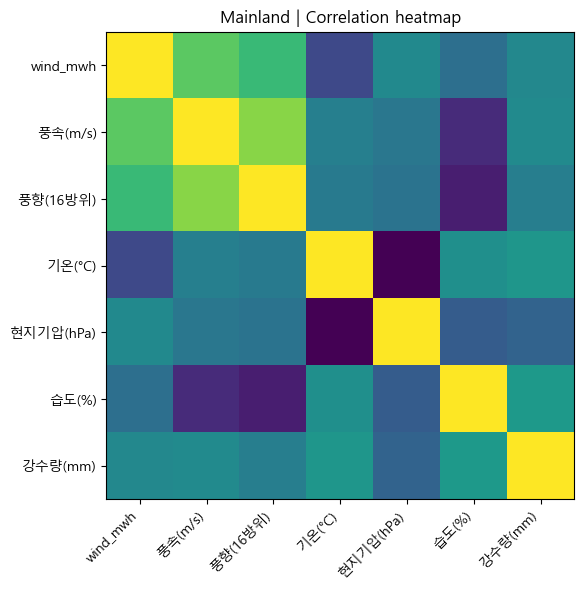

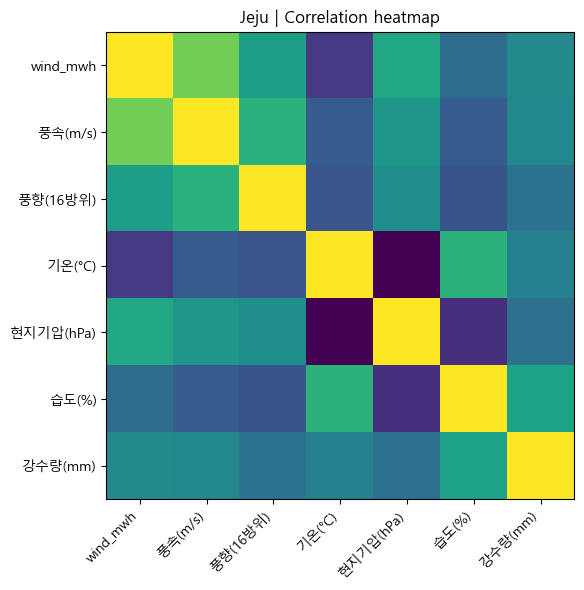

In [15]:
# 1) 상관 히트맵(지역별)
for r in ["Mainland", "Jeju"]:
    c = safe_corr(df[df["region"] == r][["wind_mwh"] + num_cols])
    corr_heatmap(c, f"{r} | Correlation heatmap")

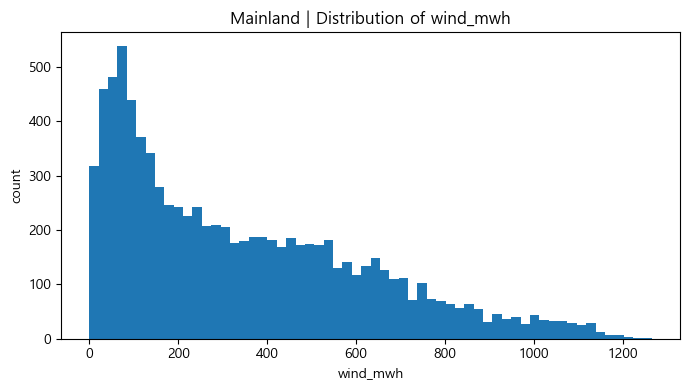

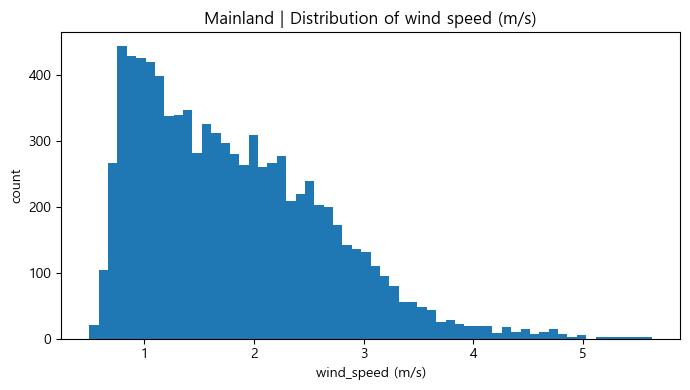

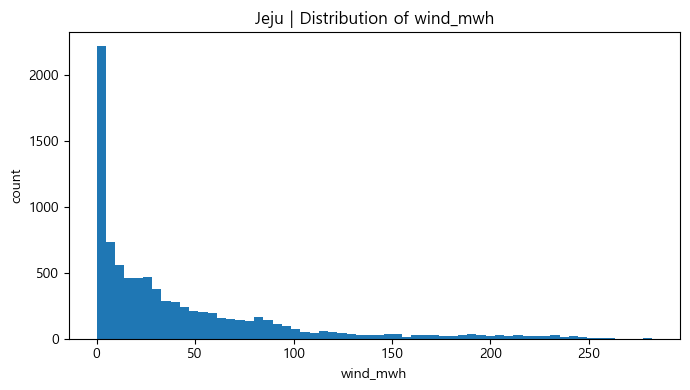

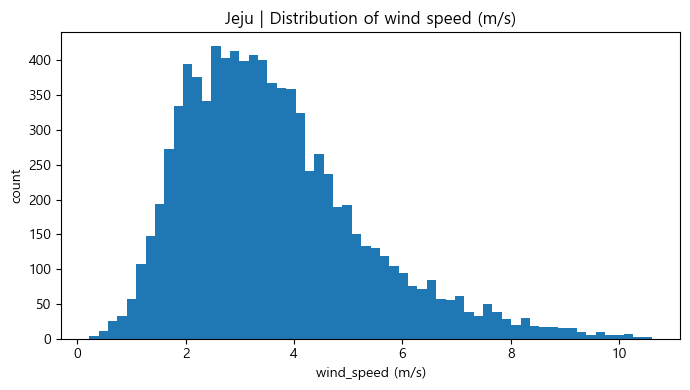

In [16]:
# 2) 분포: 발전량/풍속 히스토그램(지역별)
for r in ["Mainland", "Jeju"]:
    sub = df[df["region"] == r].copy()

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.hist(sub["wind_mwh"].dropna(), bins=60)
    ax.set_title(f"{r} | Distribution of wind_mwh")
    ax.set_xlabel("wind_mwh")
    ax.set_ylabel("count")
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.hist(sub["풍속(m/s)"].dropna(), bins=60)
    ax.set_title(f"{r} | Distribution of wind speed (m/s)")
    ax.set_xlabel("wind_speed (m/s)")
    ax.set_ylabel("count")
    plt.tight_layout()
    plt.show()

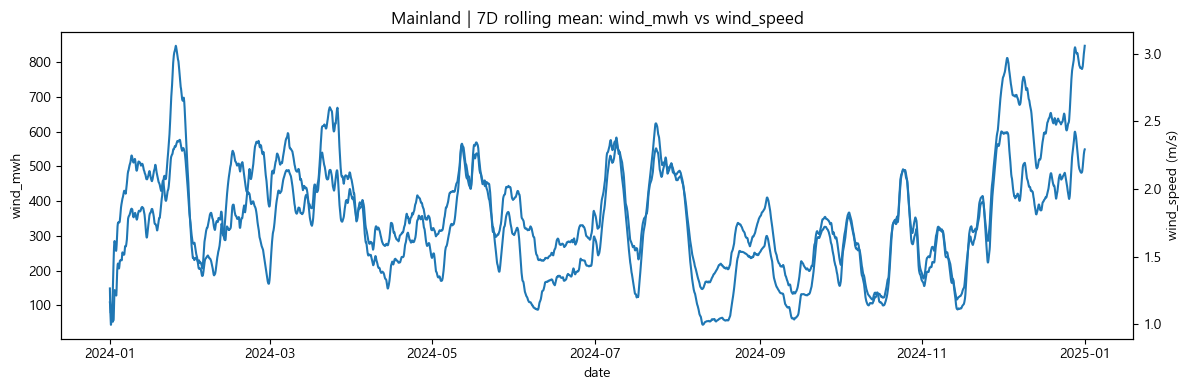

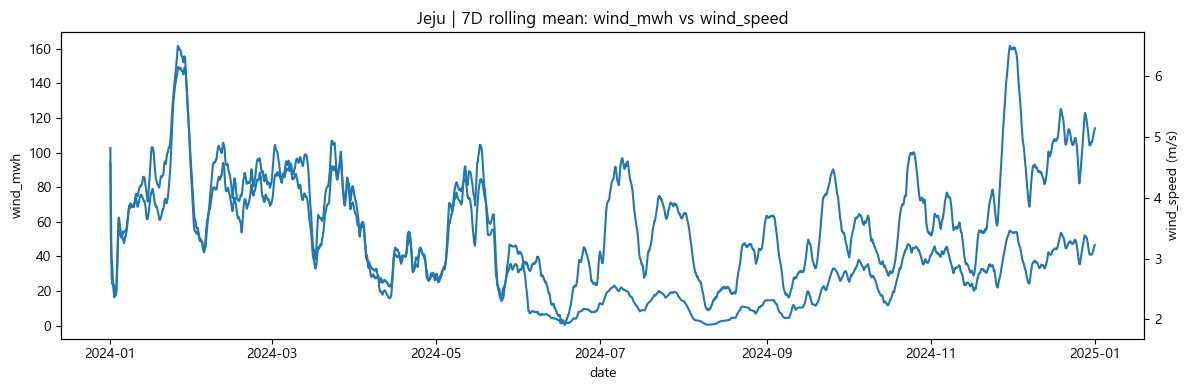

In [17]:
# 3) 시계열: 7일 이동평균(발전량 vs 풍속, twin axis)
for r in ["Mainland", "Jeju"]:
    sub = df[df["region"] == r].set_index("dt").sort_index()
    roll = sub[["wind_mwh", "풍속(m/s)"]].rolling("7D").mean()

    fig, ax1 = plt.subplots(figsize=(12, 4))
    ax1.plot(roll.index, roll["wind_mwh"])
    ax1.set_title(f"{r} | 7D rolling mean: wind_mwh vs wind_speed")
    ax1.set_xlabel("date")
    ax1.set_ylabel("wind_mwh")

    ax2 = ax1.twinx()
    ax2.plot(roll.index, roll["풍속(m/s)"])
    ax2.set_ylabel("wind_speed (m/s)")
    plt.tight_layout()
    plt.show()

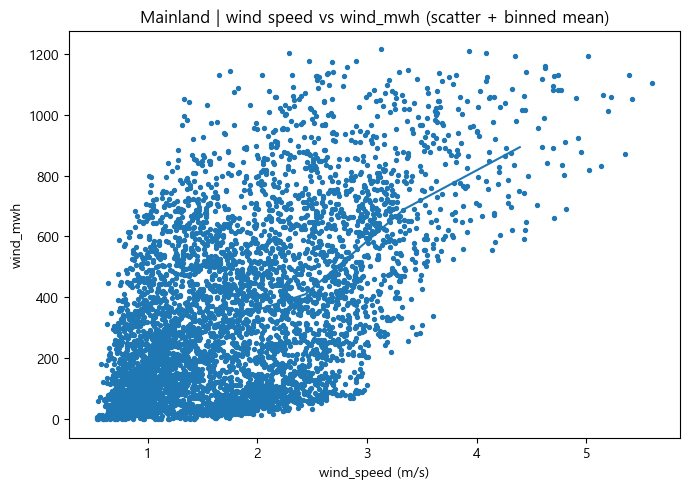

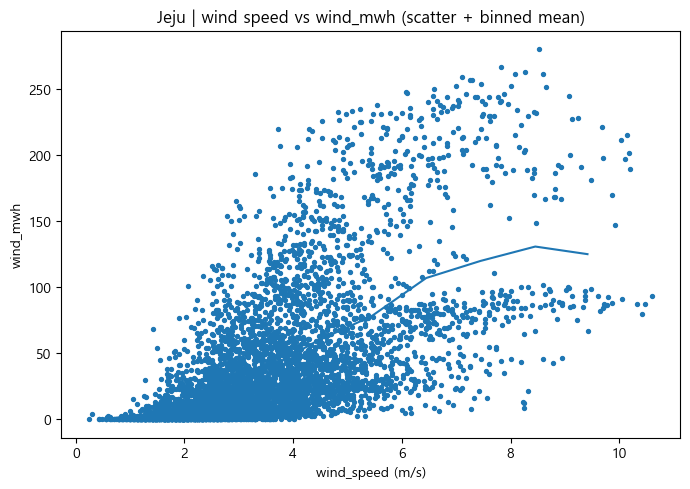

In [18]:
# 4) 산점도 + 풍속 bin 평균 곡선
rng = np.random.default_rng(42)
for r in ["Mainland", "Jeju"]:
    sub = df[(df["region"] == r)].dropna(subset=["풍속(m/s)", "wind_mwh"]).copy()
    samp = sub if len(sub) <= 5000 else sub.sample(5000, random_state=42)

    bt = bins_df[(bins_df["region"] == r) & (bins_df["n"] > 30)].copy()

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(samp["풍속(m/s)"], samp["wind_mwh"], s=8)
    ax.plot(bt["mean_speed"], bt["mean_mwh"])
    ax.set_title(f"{r} | wind speed vs wind_mwh (scatter + binned mean)")
    ax.set_xlabel("wind_speed (m/s)")
    ax.set_ylabel("wind_mwh")
    plt.tight_layout()
    plt.show()

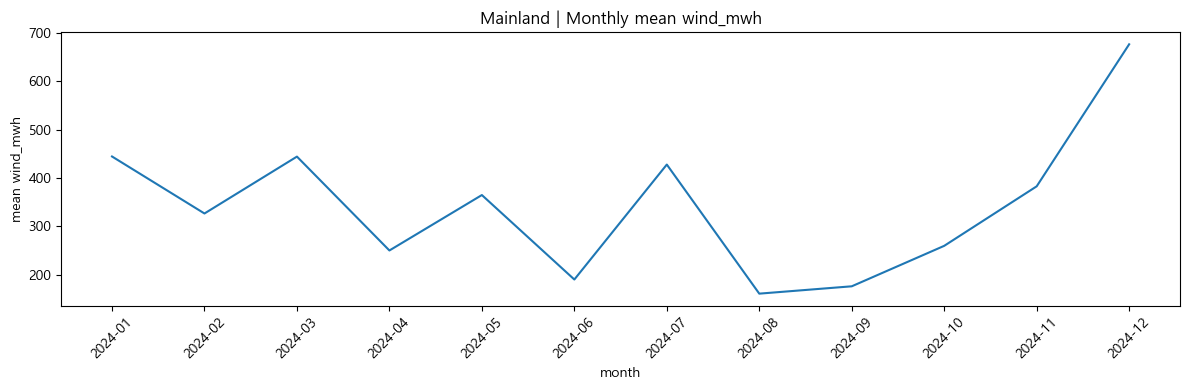

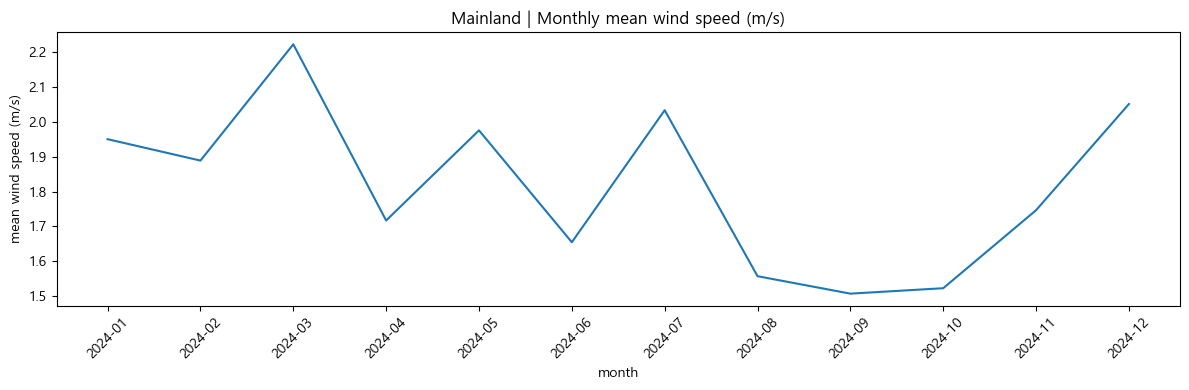

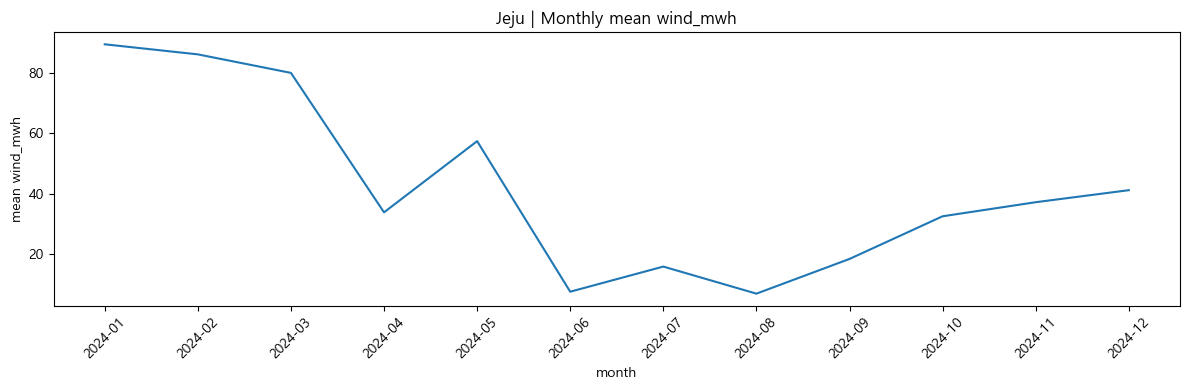

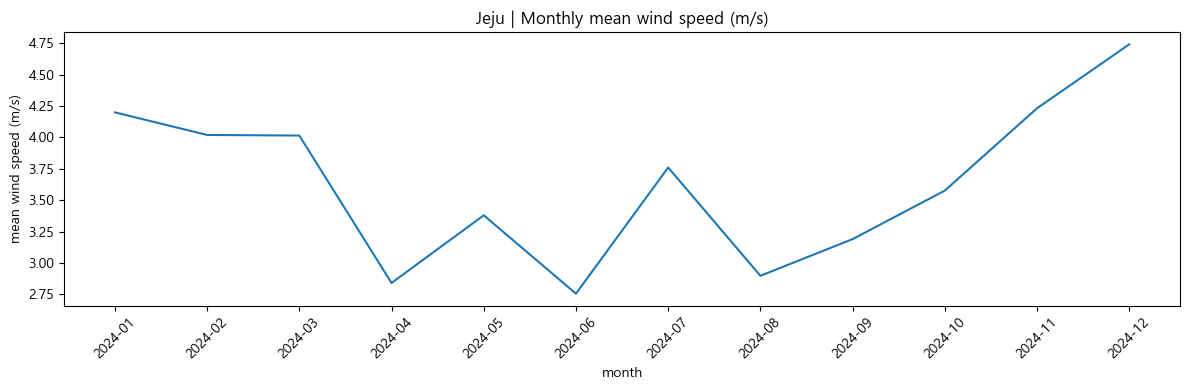

In [19]:
# 5) 월별 패턴(라인): 월별 평균 발전량 & 평균 풍속
for r in ["Mainland", "Jeju"]:
    sub = monthly[monthly["region"] == r].copy()
    sub = sub.sort_values("month")

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(sub["month"], sub["mean_mwh"])
    ax.set_title(f"{r} | Monthly mean wind_mwh")
    ax.set_xlabel("month")
    ax.set_ylabel("mean wind_mwh")
    ax.tick_params(axis="x", rotation=45)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(sub["month"], sub["mean_speed"])
    ax.set_title(f"{r} | Monthly mean wind speed (m/s)")
    ax.set_xlabel("month")
    ax.set_ylabel("mean wind speed (m/s)")
    ax.tick_params(axis="x", rotation=45)
    plt.tight_layout()
    plt.show()

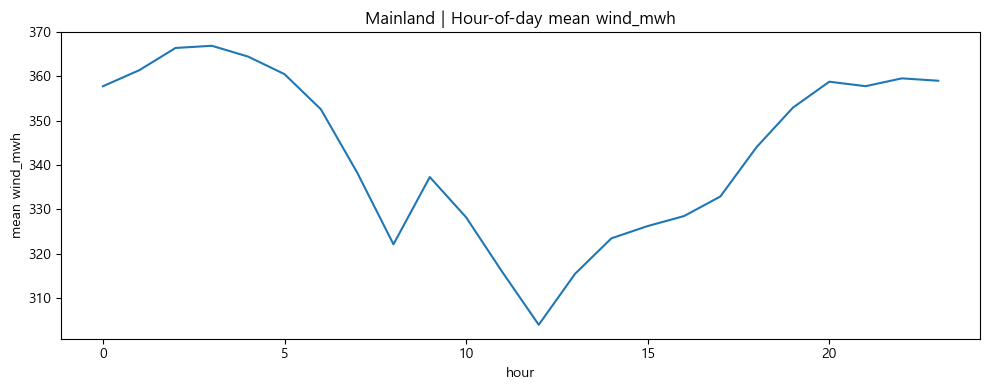

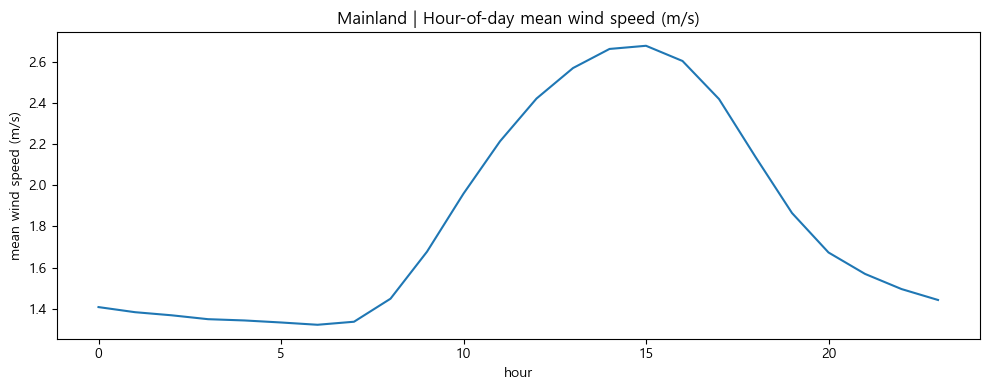

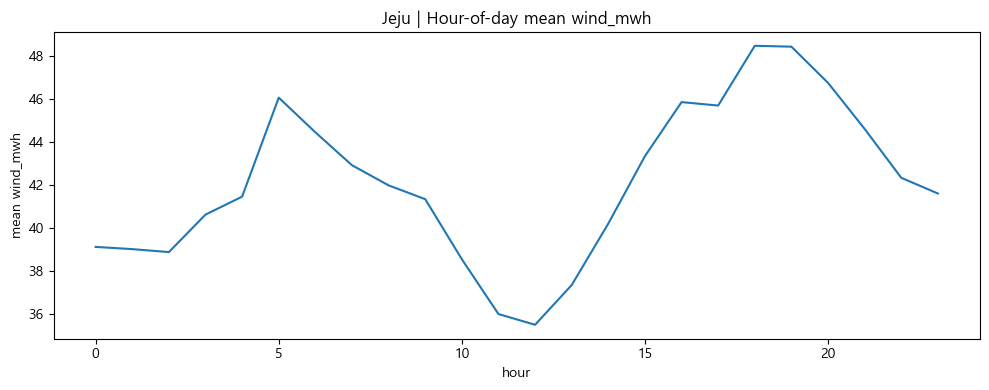

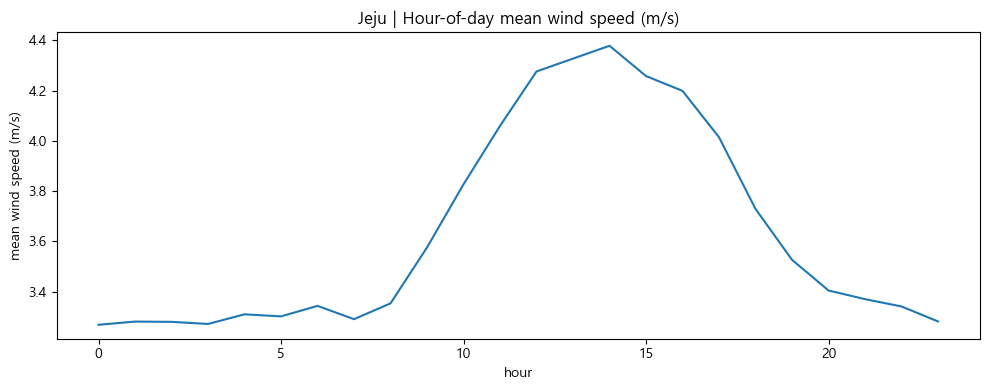

In [20]:
# 6) 시간대(일중) 패턴(라인): 시간별 평균 발전량 & 평균 풍속
for r in ["Mainland", "Jeju"]:
    sub = hourly[hourly["region"] == r].sort_values("hour")

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(sub["hour"], sub["mean_mwh"])
    ax.set_title(f"{r} | Hour-of-day mean wind_mwh")
    ax.set_xlabel("hour")
    ax.set_ylabel("mean wind_mwh")
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(sub["hour"], sub["mean_speed"])
    ax.set_title(f"{r} | Hour-of-day mean wind speed (m/s)")
    ax.set_xlabel("hour")
    ax.set_ylabel("mean wind speed (m/s)")
    plt.tight_layout()
    plt.show()


[EDA-plot table) Mainland wind_dir_code -> mean_mwh]
 풍향(16방위)   mean_mwh  n
61.612903  70.728730  1
62.795699 132.019250  1
66.521739 213.943397  1
67.956989  82.349436  1
68.064516  48.735562  1
68.817204 234.404196  1
69.247312  72.898721  1
70.430108 124.941729  1
70.752688 163.238746  1
71.086957 113.697800  1
71.290323  54.025428  1
71.612903  12.485587  1
72.150538  60.493127  1
73.478261 110.898663  2
73.548387 111.291641  1
73.586957 140.772224  2
73.763441 212.243561  2
74.086022  93.167259  1
74.193548  69.902110  1
74.347826  51.305055  1
74.516129 178.500174  1
74.623656  50.458050  1
75.161290  54.759464  1
75.326087  17.391895  1
75.591398  38.717194  2
75.913978  77.928777  1
76.236559  82.076739  1
76.344086  74.376998  2
76.451613  29.208583  1
76.559140  94.839491  1
76.989247   9.601618  1
77.204301  20.534500  1
77.419355  26.668637  2
77.526882   3.636172  1
77.717391 215.703134  1
77.741935  38.011950  2
77.849462  73.321836  3
77.956989  45.789678  1
78.152174 

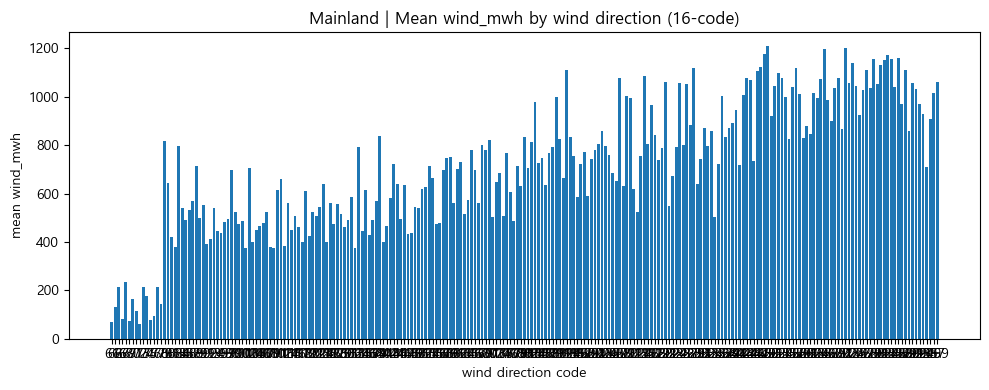


[EDA-plot table) Jeju wind_dir_code -> mean_mwh]
  풍향(16방위)  mean_mwh   n
 10.000000  1.829968   1
 12.500000  0.950163   5
 15.000000  1.067836   1
 17.500000 22.833311   3
 22.500000  1.349197   3
 23.333333  0.009448   1
 25.000000  1.953696   3
 27.500000 61.387440   3
 30.000000  7.388468   7
 32.500000  0.000000   1
 33.333333  0.047082   1
 35.000000 44.438682  17
 37.500000  4.685891   4
 40.000000 26.927057  16
 42.500000 48.574727  17
 45.000000 12.046406  17
 47.500000 41.883193  45
 50.000000 35.943890  39
 52.500000 41.199561  77
 53.333333  0.338429   2
 55.000000 57.956977  70
 57.500000 37.881676  77
 60.000000 58.495366 134
 62.500000 28.581450  48
 65.000000 55.141165 144
 67.500000 24.381216  43
 70.000000 49.999377 132
 72.500000 25.381471  44
 73.333333  1.537820   1
 75.000000 44.881377 115
 76.666667  0.541443   1
 77.500000 32.252703  43
 80.000000 36.383767 113
 82.500000 33.160441  48
 83.333333  0.979668   2
 85.000000 38.509988 119
 87.500000 32.827438 101


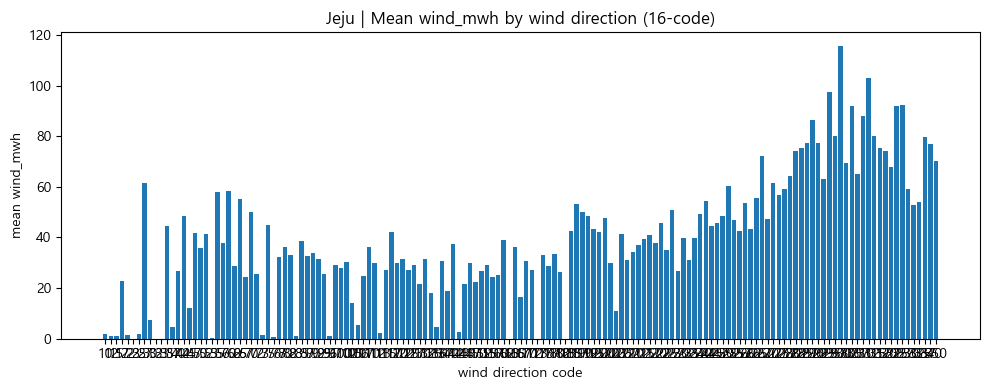

In [21]:
# 7) 풍향(16방위)별 평균 발전량 (간단 해석용)
# 풍향 값이 0~16 범위(코드)로 들어오는 경우가 많아, 코드별 평균 발전량 막대그래프로 확인
for r in ["Mainland", "Jeju"]:
    sub = df[(df["region"] == r)].dropna(subset=["풍향(16방위)", "wind_mwh"]).copy()
    wd_mean = (sub.groupby("풍향(16방위)", as_index=False)
                 .agg(mean_mwh=("wind_mwh", "mean"), n=("wind_mwh", "size"))
                 .sort_values("풍향(16방위)"))

    show_df(f"EDA-plot table) {r} wind_dir_code -> mean_mwh", wd_mean)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(wd_mean["풍향(16방위)"].astype(int).astype(str), wd_mean["mean_mwh"])
    ax.set_title(f"{r} | Mean wind_mwh by wind direction (16-code)")
    ax.set_xlabel("wind direction code")
    ax.set_ylabel("mean wind_mwh")
    plt.tight_layout()
    plt.show()


[Mainland] RF time-split R2 = 0.459

[EDA-Model) Mainland feature importances]
           feature  importance
wind_power_density    0.325184
           풍속(m/s)    0.148616
            hour_i    0.125620
             습도(%)    0.122478
            기온(°C)    0.078459
           month_i    0.059520
            wd_sin    0.051997
       air_density    0.048879
            wd_cos    0.027263
           강수량(mm)    0.011984


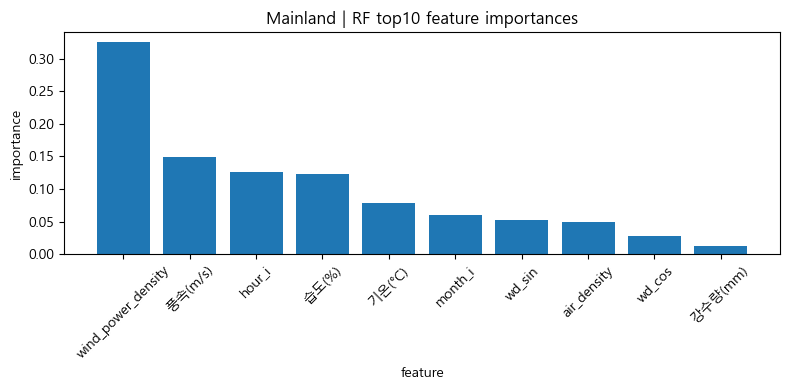


[Jeju] RF time-split R2 = 0.576

[EDA-Model) Jeju feature importances]
           feature  importance
wind_power_density    0.492277
           month_i    0.260741
            기온(°C)    0.075983
             습도(%)    0.046119
            hour_i    0.034414
            wd_cos    0.024938
       air_density    0.024090
            wd_sin    0.022234
           풍속(m/s)    0.016061
           강수량(mm)    0.003142


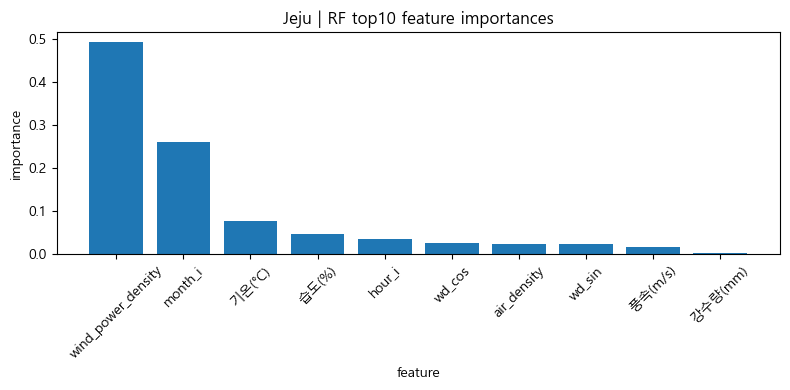


Done.


In [22]:
# =========================
# (옵션) 드라이버 정량화: 간단 모델 + 중요도 표/그래프
# =========================
def add_phys_features(frame):
    out = frame.copy()

    # 시간 피처
    out["month_i"] = out["dt"].dt.month
    out["hour_i"]  = out["dt"].dt.hour

    # 풍향 sin/cos (풍향 코드가 각도와 1:1이 아닐 수 있어도, 원형성 처리 목적)
    wd = np.deg2rad(out["풍향(16방위)"])
    out["wd_sin"] = np.sin(wd)
    out["wd_cos"] = np.cos(wd)

    # 공기밀도/풍력밀도
    T = out["기온(°C)"] + 273.15
    P = out["현지기압(hPa)"] * 100.0
    out["air_density"] = P / (287.05 * T)
    out["wind_power_density"] = 0.5 * out["air_density"] * (out["풍속(m/s)"] ** 3)
    return out

df_f = add_phys_features(df)

feat = ["풍속(m/s)", "wind_power_density", "air_density",
        "기온(°C)", "습도(%)", "강수량(mm)",
        "wd_sin", "wd_cos", "month_i", "hour_i"]

for r in ["Mainland", "Jeju"]:
    sub = df_f[df_f["region"] == r].sort_values("dt").copy()
    X = sub[feat]
    y = sub["wind_mwh"]

    k = int(len(sub) * 0.8)  # time split (EDA용)
    X_tr, X_te = X.iloc[:k], X.iloc[k:]
    y_tr, y_te = y.iloc[:k], y.iloc[k:]

    model = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("rf", RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, min_samples_leaf=5)),
    ])

    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)
    r2 = r2_score(y_te, pred)

    importances = model.named_steps["rf"].feature_importances_
    imp_tbl = pd.DataFrame({"feature": feat, "importance": importances}).sort_values("importance", ascending=False)

    print(f"\n[{r}] RF time-split R2 = {r2:.3f}")
    show_df(f"EDA-Model) {r} feature importances", imp_tbl)

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(imp_tbl["feature"].head(10), imp_tbl["importance"].head(10))
    ax.set_title(f"{r} | RF top10 feature importances")
    ax.set_xlabel("feature")
    ax.set_ylabel("importance")
    ax.tick_params(axis="x", rotation=45)
    plt.tight_layout()
    plt.show()

print("\nDone.")